In [1]:
# Add scripts to path and fix working directory
import sys
import os
from pathlib import Path

# Change to project root (two levels up from notebook)
notebook_dir = Path.cwd()
project_root = notebook_dir.parent.parent.parent if hasattr(notebook_dir, 'parent') else Path("/home/Plutonium/Documents/BioinfoMidterm")
os.chdir(project_root)
sys.path.insert(0, str(project_root / "scripts"))

print(f"Working directory: {os.getcwd()}")

# Import config module and set population FIRST
import config as cfg
cfg.set_population_config("sea_jpt_cn")

# Now create aliases (pointing to updated config)
PATHS = cfg.PATHS
SITUATIONAL_FILTERS = cfg.SITUATIONAL_FILTERS
POPULATIONS = cfg.POPULATIONS

# Import other modules
from utils import analyze_fst, merge_fst_top_variants, variants_to_bed_file, count_variants
from fst_selection import (
    add_population_to_psam,
    calculate_pairwise_fst,
    find_fst_files,
    analyze_all_fst_files,
    select_top_fst_variants,
    extract_fst_variants,
)
from situational_filters import calculate_pca

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Working directory: /home/Plutonium/Documents/BioinfoMidterm


In [2]:
# Configuration
INPUT_PFILE = str(PATHS.PLINK_LD_PRUNED)
SAMPLES_CSV = str(PATHS.EAS_SAMPLES_CSV)
OUTPUT_DIR = str(PATHS.OUTPUT_DIR)

print(f"Input pfile: {INPUT_PFILE}")
print(f"Samples CSV: {SAMPLES_CSV}")
print(f"FST top N: {SITUATIONAL_FILTERS.FST_TOP_N}")
print(f"Variants: {count_variants(INPUT_PFILE)}")

Input pfile: 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_FINAL_DATA_FOR_FST
Samples CSV: 1000genomes/SEA_JPT_CN_subpopulation_samples.csv
FST top N: 1000
Variants: 599223


## Step 1: Add Population Labels to PSAM

FST calculation requires population labels in the .psam file.

In [3]:
# Add population labels
psam_path = f"{INPUT_PFILE}.psam"

# Create a backup first
import shutil
backup_path = f"{psam_path}.backup"
if not os.path.exists(backup_path):
    shutil.copy(psam_path, backup_path)
    print(f"Backup created: {backup_path}")

# Add population labels
add_population_to_psam(
    psam_path,
    SAMPLES_CSV,
    output_path=psam_path,
)

# Verify
psam_df = pd.read_csv(psam_path, sep="\t")
print("\nUpdated .psam file:")
display(psam_df.head())
print(f"\nPopulation counts:")
display(psam_df['pop'].value_counts())

Backup created: 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_FINAL_DATA_FOR_FST.psam.backup
Added population labels to psam file
  Samples: 504
  Populations: {'CN': 208, 'SEA': 192, 'JPT': 104}

Updated .psam file:


,#IID,pop
0,HG00403,CN
1,HG00404,CN
2,HG00406,CN
3,HG00407,CN
4,HG00409,CN



Population counts:


pop
CN     208
SEA    192
JPT    104
Name: count, dtype: int64

## Step 2: Calculate Pairwise FST

FST (Fixation Index) measures genetic differentiation between populations.
- FST = 0: No differentiation (same allele frequencies)
- FST = 1: Complete differentiation (fixed for different alleles)

In [4]:
# Calculate FST
fst_prefix = calculate_pairwise_fst(
    INPUT_PFILE,
    output_prefix=str(PATHS.FST_RESULTS),
    pop_column="pop",
)

FST CALCULATION
  Input: 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_FINAL_DATA_FOR_FST
  Population column: pop
Running: plink2 --threads 8 --pfile 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_FINAL_DATA_FOR_FST --fst pop report-variants --out 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_FST_RESULTS


PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_FST_RESULTS.log.
Options in effect:
  --fst pop report-variants
  --out 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_FST_RESULTS
  --pfile 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_FINAL_DATA_FOR_FST
  --threads 8

Start time: Sun Feb  1 12:36:41 2026
15686 MiB RAM detected, ~10673 available; reserving 7843 MiB for main
workspace.
Using up to 8 compute threads.
504 samples (0 females, 0 males, 504 ambiguous; 504 founders) loaded from
1000genomes/output_sea_jpt_cn/SEA_JPT_CN_FINAL_DATA_FOR_FST.psam.
599223 variants loaded from
1000genomes/output_sea_jpt_cn/SEA_JPT_CN_FINAL_DATA_FOR_FST.pvar.
1 categorical phenotype loaded (504 values).
--fst: Analyzing 504 samples across 3 populations.
Autosomal --fst: 102132435465768798done.
Autosomal --fst: 3 .fst.var files written.
Autosomal --fst: 

In [5]:
# Find FST files
fst_files = find_fst_files(fst_prefix)

# List pairwise comparisons
print("\nPairwise FST comparisons:")
for f in fst_files:
    print(f"  - {os.path.basename(f)}")

Found 3 FST files:
  - SEA_JPT_CN_FST_RESULTS.CN.JPT.fst.var
  - SEA_JPT_CN_FST_RESULTS.JPT.SEA.fst.var
  - SEA_JPT_CN_FST_RESULTS.CN.SEA.fst.var

Pairwise FST comparisons:
  - SEA_JPT_CN_FST_RESULTS.CN.JPT.fst.var
  - SEA_JPT_CN_FST_RESULTS.JPT.SEA.fst.var
  - SEA_JPT_CN_FST_RESULTS.CN.SEA.fst.var


## Step 3: Analyze FST Distribution

In [6]:
# Analyze all FST files
all_fst, top_fst = analyze_all_fst_files(
    fst_prefix,
    top_n=SITUATIONAL_FILTERS.FST_TOP_N,
    plot=False,
)

Found 3 FST files:
  - SEA_JPT_CN_FST_RESULTS.CN.JPT.fst.var
  - SEA_JPT_CN_FST_RESULTS.JPT.SEA.fst.var
  - SEA_JPT_CN_FST_RESULTS.CN.SEA.fst.var

Analyzing: CN.JPT
Loading FST file: 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_FST_RESULTS.CN.JPT.fst.var


   #CHROM    POS               ID  OBS_CT  HUDSON_FST
0       1  13116  1:13116[b37]T,G     312    0.044101
1       1  13273  1:13273[b37]G,C     312    0.027190
2       1  13289  1:13289[b37]C,T     312    0.000000
3       1  13543  1:13543[b37]T,G     312    0.000000
4       1  14599  1:14599[b37]T,A     312    0.064178
              #CHROM           POS    OBS_CT     HUDSON_FST
count  599223.000000  5.992230e+05  599223.0  578265.000000
mean        9.111264  7.777228e+07     312.0       0.004045
std         6.034992  5.860037e+07       0.0       0.009922
min         1.000000  6.840000e+02     312.0      -0.003620
25%         4.000000  2.855351e+07     312.0      -0.002405
50%         8.000000  6.703072e+07     312.0       0.000755
75%        14.000000  1.164652e+08     312.0       0.006524
max        22.000000  2.492385e+08     312.0       0.247830
Total variants: 599223
NaN FST: 20958
Negative FST: 213134
Zero FST: 40588
Positive FST: 324543

Top 1000 variants:
        #CHROM      

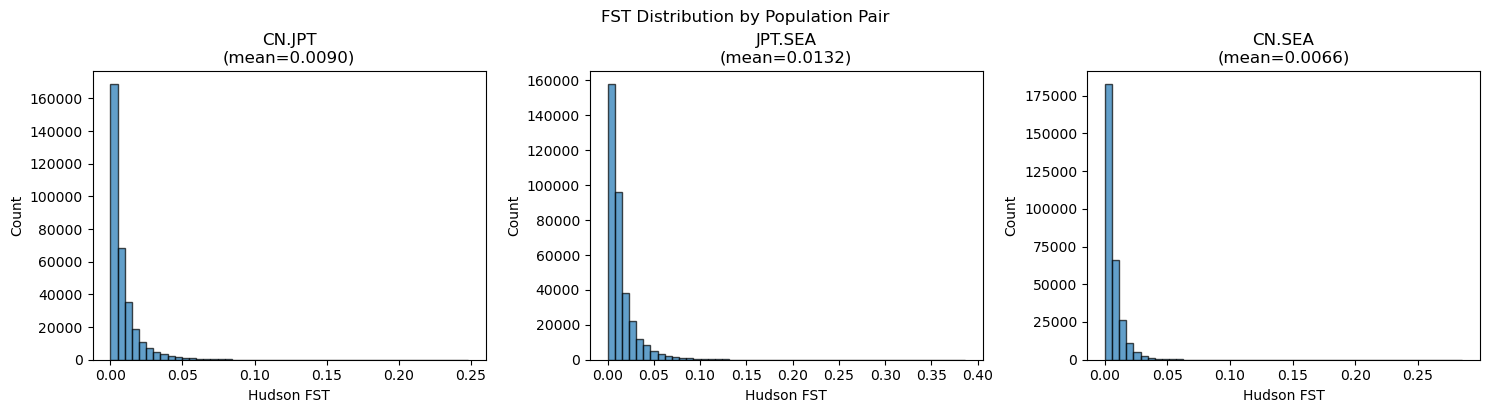

In [7]:
# Visualize FST distributions
n_comparisons = len(all_fst)
fig, axes = plt.subplots(1, n_comparisons, figsize=(5*n_comparisons, 4))

if n_comparisons == 1:
    axes = [axes]

for ax, (comparison, df) in zip(axes, all_fst.items()):
    fst_valid = df['HUDSON_FST'].dropna()
    fst_positive = fst_valid[fst_valid > 0]
    
    ax.hist(fst_positive, bins=50, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Hudson FST')
    ax.set_ylabel('Count')
    ax.set_title(f'{comparison}\n(mean={fst_positive.mean():.4f})')

plt.tight_layout()
plt.suptitle('FST Distribution by Population Pair', y=1.02)
plt.show()

In [8]:
# Summary statistics for each comparison
print("FST Summary Statistics:")
print("="*60)

for comparison, df in all_fst.items():
    fst_valid = df['HUDSON_FST'].dropna()
    fst_positive = fst_valid[fst_valid > 0]
    
    print(f"\n{comparison}:")
    print(f"  Total variants: {len(df)}")
    print(f"  Valid FST: {len(fst_valid)}")
    print(f"  Positive FST: {len(fst_positive)}")
    print(f"  Mean FST: {fst_positive.mean():.6f}")
    print(f"  Max FST: {fst_positive.max():.6f}")

FST Summary Statistics:

CN.JPT:
  Total variants: 599223
  Valid FST: 578265
  Positive FST: 324543
  Mean FST: 0.008990
  Max FST: 0.247830

JPT.SEA:
  Total variants: 599223
  Valid FST: 581037
  Positive FST: 349409
  Mean FST: 0.013240
  Max FST: 0.386240

CN.SEA:
  Total variants: 599223
  Valid FST: 586712
  Positive FST: 297345
  Mean FST: 0.006620
  Max FST: 0.285170


## Step 4: Select Top FST Variants

In [9]:
# Select top variants
merged_df, top_snps_file = select_top_fst_variants(
    fst_prefix,
    output_file=str(PATHS.TOP_SNPS_FILE),
    top_n=SITUATIONAL_FILTERS.FST_TOP_N,
)

print(f"\nTop FST variants:")
display(merged_df.head(10))

Found 3 FST files:
  - SEA_JPT_CN_FST_RESULTS.CN.JPT.fst.var
  - SEA_JPT_CN_FST_RESULTS.JPT.SEA.fst.var
  - SEA_JPT_CN_FST_RESULTS.CN.SEA.fst.var

Analyzing: CN.JPT
Loading FST file: 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_FST_RESULTS.CN.JPT.fst.var
   #CHROM    POS               ID  OBS_CT  HUDSON_FST
0       1  13116  1:13116[b37]T,G     312    0.044101
1       1  13273  1:13273[b37]G,C     312    0.027190
2       1  13289  1:13289[b37]C,T     312    0.000000
3       1  13543  1:13543[b37]T,G     312    0.000000
4       1  14599  1:14599[b37]T,A     312    0.064178
              #CHROM           POS    OBS_CT     HUDSON_FST
count  599223.000000  5.992230e+05  599223.0  578265.000000
mean        9.111264  7.777228e+07     312.0       0.004045
std         6.034992  5.860037e+07       0.0       0.009922
min         1.000000  6.840000e+02     312.0      -0.003620
25%         4.000000  2.855351e+07     312.0      -0.002405
50%         8.000000  6.703072e+07     312.0       0.000755
75%  

,#CHROM,POS,ID,OBS_CT,HUDSON_FST
0,16,46417894,"16:46417894[b37]G,A",312,0.247830
1,3,83842624,"3:83842624[b37]G,A",312,0.196357
2,21,47054067,"21:47054067[b37]A,G",312,0.191094
3,17,22261227,"17:22261227[b37]G,A",312,0.177473
4,21,42335080,"21:42335080[b37]C,G",312,0.173854
5,6,32011714,"6:32011714[b37]A,G",312,0.170975
6,6,29611431,"6:29611431[b37]C,T",312,0.163342
7,6,87238638,"6:87238638[b37]G,A",312,0.162852
8,2,11994492,"2:11994492[b37]G,T",312,0.162275
9,11,61375236,"11:61375236[b37]T,G",312,0.161781


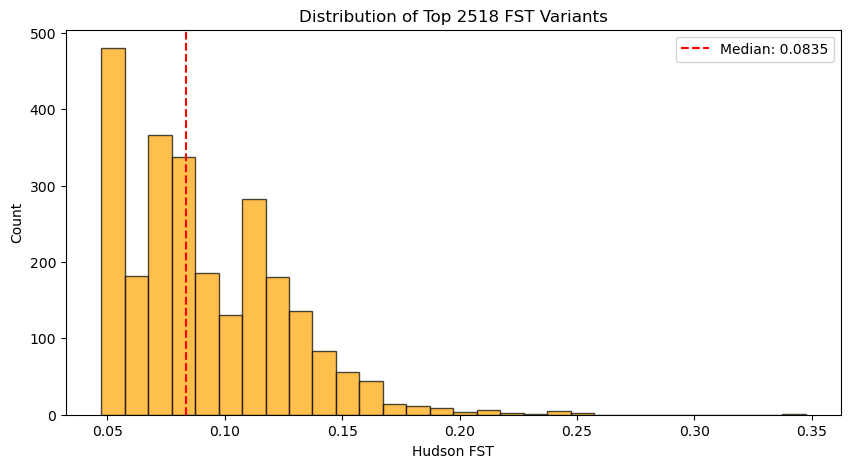

In [10]:
# Visualize top FST variants
plt.figure(figsize=(10, 5))

plt.hist(merged_df['HUDSON_FST'], bins=30, edgecolor='black', alpha=0.7, color='orange')
plt.xlabel('Hudson FST')
plt.ylabel('Count')
plt.title(f'Distribution of Top {len(merged_df)} FST Variants')
plt.axvline(merged_df['HUDSON_FST'].median(), color='red', linestyle='--', 
            label=f'Median: {merged_df["HUDSON_FST"].median():.4f}')
plt.legend()
plt.show()

In [11]:
# Convert to BED format
bed_file = str(PATHS.TOP_SNPS_BED)
variants_to_bed_file(top_snps_file, bed_file)

Converted 2518 variants to BED format: 1000genomes/output_sea_jpt_cn/top_snps.bed


2518

## Step 5: Extract FST-Selected Variants

In [12]:
# Extract variants
fst_filtered = extract_fst_variants(
    str(PATHS.PLINK_UNIQUE_IDS),  # Use pfile with unique IDs
    top_snps_file,
    output_pfile=str(PATHS.FST_FILTERED),
)

print(f"\nExtracted variants: {count_variants(fst_filtered)}")

Extracting FST-selected variants...
Running: plink2 --threads 8 --pfile 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_SNP_MAF_HWE_filtered_unique_ids --extract 1000genomes/output_sea_jpt_cn/top_snps.txt --make-pgen --out 1000genomes/output_sea_jpt_cn/FST_FILTERED
PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to 1000genomes/output_sea_jpt_cn/FST_FILTERED.log.
Options in effect:
  --extract 1000genomes/output_sea_jpt_cn/top_snps.txt
  --make-pgen
  --out 1000genomes/output_sea_jpt_cn/FST_FILTERED
  --pfile 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_SNP_MAF_HWE_filtered_unique_ids
  --threads 8

Start time: Sun Feb  1 12:36:48 2026
15686 MiB RAM detected, ~10276 available; reserving 7843 MiB for main
workspace.
Using up to 8 compute threads.
504 samples (0 females, 0 males, 504 ambiguous; 504 founders) loaded from
1000genomes/output_sea_jpt_cn/SEA_JPT_CN_SNP_MAF_HWE_filtered_un

## Step 6: PCA Analysis

In [13]:
# Calculate PCA on FST-selected variants
pca_prefix = calculate_pca(
    fst_filtered,
    output_prefix=str(PATHS.PCA_FILE),
    n_components=10,
)

SITUATIONAL: PCA Calculation
  Components: 10
Running: plink2 --threads 8 --pfile 1000genomes/output_sea_jpt_cn/FST_FILTERED --pca 10 --out 1000genomes/output_sea_jpt_cn/FST_PCA
PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to 1000genomes/output_sea_jpt_cn/FST_PCA.log.
Options in effect:
  --out 1000genomes/output_sea_jpt_cn/FST_PCA
  --pca 10
  --pfile 1000genomes/output_sea_jpt_cn/FST_FILTERED
  --threads 8

Start time: Sun Feb  1 12:36:53 2026
15686 MiB RAM detected, ~10419 available; reserving 7843 MiB for main
workspace.
Using up to 8 compute threads.
504 samples (0 females, 0 males, 504 ambiguous; 504 founders) loaded from
1000genomes/output_sea_jpt_cn/FST_FILTERED.psam.
2518 variants loaded from 1000genomes/output_sea_jpt_cn/FST_FILTERED.pvar.
Note: No phenotype data present.
Calculating allele frequencies... done.
Constructing GRM: 1117222834404551576268748085

In [14]:
# Load PCA results
eigenvec = pd.read_csv(f"{pca_prefix}.eigenvec", sep=r"\s+", header=None)
eigenvec.columns = ["#IID"] + [f"PC{i}" for i in range(1, 11)]

eigenval = pd.read_csv(f"{pca_prefix}.eigenval", header=None)
eigenval.columns = ["eigenvalue"]

# Merge with population labels
pop_df = pd.read_csv(SAMPLES_CSV, header=None)
pop_df.columns = ["#IID", "POP", "SUPER_POP"]

pca_df = eigenvec.merge(pop_df[["#IID", "POP"]], on="#IID")

print(f"PCA results: {len(pca_df)} samples")
display(pca_df.head())

PCA results: 504 samples


,#IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,POP
0,HG00403,-0.0123057,0.0938576,0.021374,-0.0561191,0.0483699,-0.0576266,0.00379416,-0.0606779,0.0111248,0.0654008,CN
1,HG00404,-0.0158921,0.0755733,0.0170322,-0.0462495,0.00303975,-0.122128,-0.0460395,-0.0859313,-0.0299508,0.0150858,CN
2,HG00406,0.00537354,-0.000358767,-0.0412318,0.00247936,0.0024474,-0.0225144,-0.0205285,-0.011831,-0.00895655,0.00730683,CN
3,HG00407,0.00947658,0.0282307,-0.0366496,0.00492799,0.0115981,-0.00502967,-0.0219028,0.0156981,0.0264475,0.0061048,CN
4,HG00409,0.00540632,-0.0131609,-0.0459653,-0.0505605,0.00621216,-0.0580637,0.0313157,0.0620922,-0.0205684,-0.0396699,CN


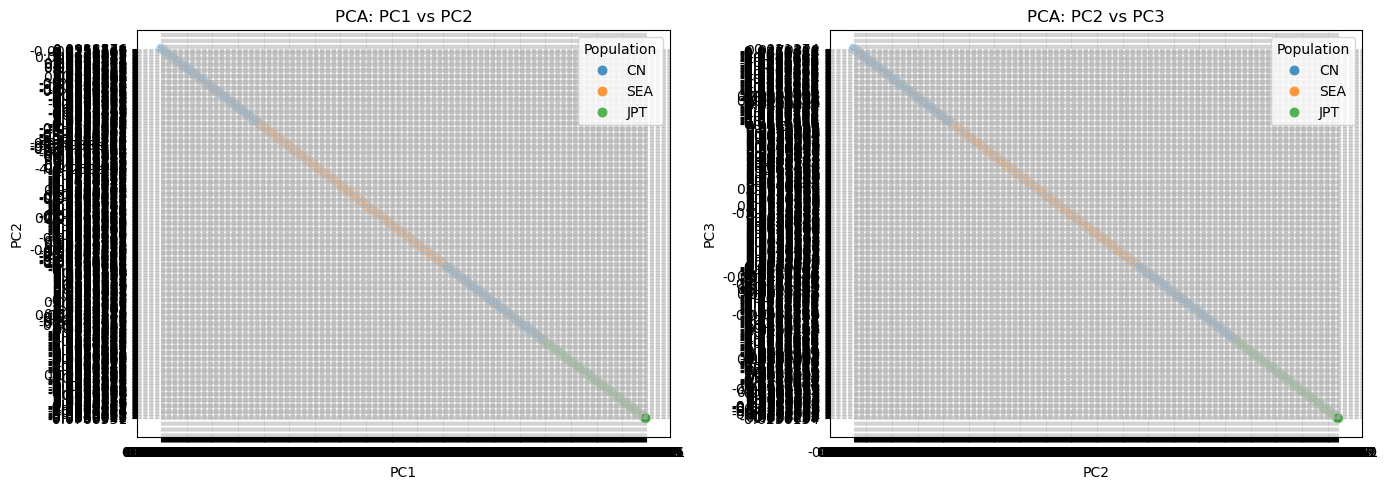

In [15]:
# Plot PC1 vs PC2
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PC1 vs PC2
sns.scatterplot(
    data=pca_df,
    x="PC1", y="PC2",
    hue="POP",
    palette="tab10",
    s=60, alpha=0.8,
    ax=axes[0],
)
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].set_title("PCA: PC1 vs PC2")
axes[0].legend(title="Population")
axes[0].grid(True, linestyle="--", alpha=0.5)

# PC2 vs PC3
sns.scatterplot(
    data=pca_df,
    x="PC2", y="PC3",
    hue="POP",
    palette="tab10",
    s=60, alpha=0.8,
    ax=axes[1],
)
axes[1].set_xlabel("PC2")
axes[1].set_ylabel("PC3")
axes[1].set_title("PCA: PC2 vs PC3")
axes[1].legend(title="Population")
axes[1].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

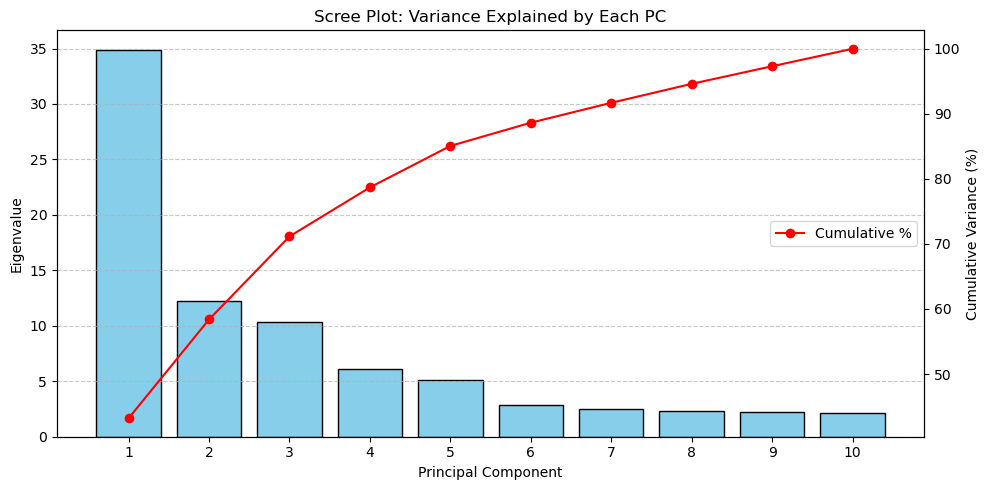

In [16]:
# Scree plot
plt.figure(figsize=(10, 5))

plt.bar(range(1, len(eigenval) + 1), eigenval["eigenvalue"], color='skyblue', edgecolor='black')
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue")
plt.title("Scree Plot: Variance Explained by Each PC")
plt.xticks(range(1, len(eigenval) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add cumulative variance line
cumvar = eigenval["eigenvalue"].cumsum() / eigenval["eigenvalue"].sum() * 100
ax2 = plt.twinx()
ax2.plot(range(1, len(eigenval) + 1), cumvar, 'r-o', label='Cumulative %')
ax2.set_ylabel('Cumulative Variance (%)')
ax2.legend(loc='right')

plt.tight_layout()
plt.show()

## Summary

In [17]:
print("="*60)
print("FST AND PCA SUMMARY")
print("="*60)
print(f"\nFST Analysis:")
print(f"  Population comparisons: {len(all_fst)}")
print(f"  Top N per comparison: {SITUATIONAL_FILTERS.FST_TOP_N}")
print(f"  Total unique top variants: {len(merged_df)}")
print(f"\nPCA:")
print(f"  Samples: {len(pca_df)}")
print(f"  Components: 10")
print(f"  Variance explained (PC1+PC2): {cumvar.iloc[1]:.1f}%")
print(f"\nOutput files:")
print(f"  - Top SNPs: {top_snps_file}")
print(f"  - BED file: {bed_file}")
print(f"  - FST filtered pfile: {fst_filtered}")
print(f"  - PCA results: {pca_prefix}.eigenvec")
print(f"\nNext step: Run 04_ml_training.ipynb")

FST AND PCA SUMMARY

FST Analysis:
  Population comparisons: 3
  Top N per comparison: 1000
  Total unique top variants: 2518

PCA:
  Samples: 504
  Components: 10
  Variance explained (PC1+PC2): 58.4%

Output files:
  - Top SNPs: 1000genomes/output_sea_jpt_cn/top_snps.txt
  - BED file: 1000genomes/output_sea_jpt_cn/top_snps.bed
  - FST filtered pfile: 1000genomes/output_sea_jpt_cn/FST_FILTERED
  - PCA results: 1000genomes/output_sea_jpt_cn/FST_PCA.eigenvec

Next step: Run 04_ml_training.ipynb
